In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.ticker
import matplotlib.cm as cm
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
%config InlineBackend.figure_format = 'svg'

# stabilities of Schamel $\sech^4$ electron hole

In [117]:
me = 1
Te = 1
mi = 100
Ti = 1

L = 80.0
vmax = 5 # 速度最大值
nx = 1000
nv = 1000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V,X=np.meshgrid(v,x)

dt = 0.05
max_steps = 1000
data_steps = 1000
data_num = int(max_steps/data_steps)+1

path = 'E:/代码/vlasov-es1d/data/'
print(data_num)
print('real time = ', max_steps*dt)
print('dx',dx)
print('dx0',x[1]-x[0])

2
real time =  50.0
dx 0.08008008008008008
dx0 0.08008008008008008


## Schamel distribution
$$ f_e (v^2>2\phi) = \exp \left[ -\frac{\left(\pm\sqrt{v^2-2\phi}+u\right)^2}{2} \right] $$
$$ f_e (v^2<2\phi) = \exp \left[ -\beta \left(\frac{v^2}{2}-\phi\right) - \frac{u^2}{2} \right] $$
其中$v$为孤波参考系中的速度，静系速度$v_0=v+u$
- 此分布下的自洽孤波，用Newton-Raphson法解出

In [22]:
u = 0.4
psi = 0.1

r1 = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
delta = 4.0/np.sqrt(r1)
b = r1*15/16/np.sqrt(psi)
beta = 1-u**2-b*np.sqrt(np.pi)*np.exp(u**2/2)

print(delta)
print(psi)
print(beta)

4.343040299105999
0.1
-3.9886089558077975


In [25]:
# psi = 0.45
xp = (x-L/2)/delta
phi_sc = 1.5*psi*np.cosh(xp)**(-4)

In [26]:
@nb.jit
def nonvec_f_fun_sech4(v,phi):
    r = 0
    v_waveframe = v
    w = v_waveframe**2/2-phi
    if v_waveframe<=-abs(2*phi)**0.5:
        r=math.exp(-(-(2*w)**0.5+u)**2/2) 
    elif v_waveframe>abs(2*phi)**0.5:
        r=math.exp(-( (2*w)**0.5+u)**2/2) 
    else:
        r =math.exp(-beta*w-u**2/2) 
    return r/(2*np.pi)**0.5
f_fun_sech4 = np.vectorize(nonvec_f_fun_sech4)

In [27]:
for count in tqdm(range(10)):
    V,Phi=np.meshgrid(v,phi_sc)
    f_matrix = f_fun_sech4(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    
    # natural BC
#     laplace[0][0]=-1
#     laplace[-1][-1]=-1

    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi_sc[1:nx-1])
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi_sc[2:nx]-phi_sc[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi_sc[1:nx-1] += dphi
    
    err = ((dphi/phi_sc[1:nx-1])**2).sum()
    if err<= 1e-5:
        print("Sucess! Iteration counts =", count)
        break
print("err =", err)

 20%|███████████████████████████                                                                                                            | 2/10 [00:00<00:03,  2.02it/s]

Sucess! Iteration counts = 2
err = 7.194504220941067e-06


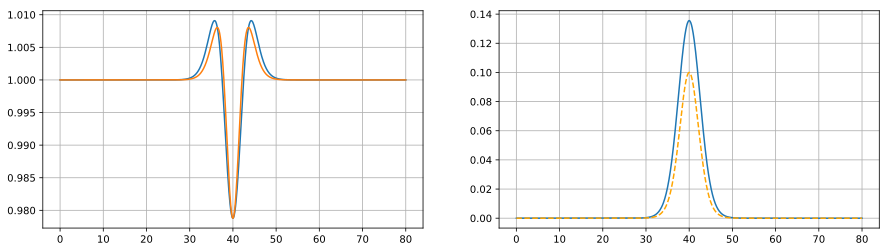

In [28]:
# psi = 0.0235
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_vector)
ax1.plot(x,1.0+psi/delta**2*(16*np.cosh(xp)**(-4)-20*np.cosh(xp)**(-6)))
ax1.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi_sc)
ax3.plot(x,psi*np.cosh((x-L/2)/delta)**(-4),color='orange',linestyle='--')
ax3.grid()
# ax3.set_xlim(0.3*L,0.7*L)
plt.show()

In [29]:
def phi4_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-4)

def phi2_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-2)

from scipy.optimize import curve_fit
para4,pcov=curve_fit(phi4_theo,x,phi_sc)
Ddelta = round(abs(para4[1]-delta)/para4[1]*100,2)
Dpsi = round(abs(para4[0]-psi)/para4[0]*100,2)  

print('sech4 fit:')
print('psi    = ',para4[0])
print('delta  = ',para4[1])
# print('Dpsi     :',Dpsi,'%')
# print('Ddelta   :',Ddelta,'%')
print('v_edge = ',np.sqrt(2*para4[0]))

sech4 fit:
psi    =  0.13671689262342343
delta  =  4.862269377297559
v_edge =  0.5229089645883371


In [120]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

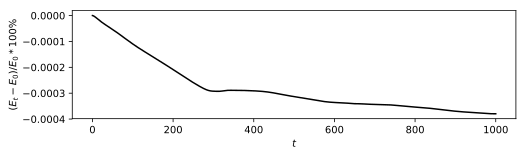

In [121]:
fig = plt.figure(figsize=(8, 2))

# plt.plot(t, (dataek-dataek[0])/dataek[0]*100, color='black')
plt.plot(t, (dataet-dataet[0])/dataet[0]*100, color='black')
plt.ylabel(r'$(E_t-E_0)/E_0*100\%$')
plt.xlabel(r'$t$')
plt.show()

In [122]:
progesses = np.arange(0,data_num,1)

fe = []
phi = []
fi = []

for progess in tqdm(progesses):
    fe_temp = np.loadtxt(os.path.join(path,"fe"+str(progess)))
    fe.append(fe_temp)
    fi_temp = np.loadtxt(os.path.join(path,"fi"+str(progess)))
    fi.append(fi_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


In [123]:
# test_frame = data_num-1
test_frame = 1
fex0 = np.sum(fe[0],axis=1)*dv
fev0 = np.sum(fe[0],axis=0)*dx/L
fex = np.sum(fe[test_frame],axis=1)*dv
fev = np.sum(fe[test_frame],axis=0)*dx/L
fix0 = np.sum(fi[0],axis=1)*dv
fiv0 = np.sum(fi[0],axis=0)*dx/L
fix = np.sum(fi[test_frame],axis=1)*dv
fiv = np.sum(fi[test_frame],axis=0)*dx/L

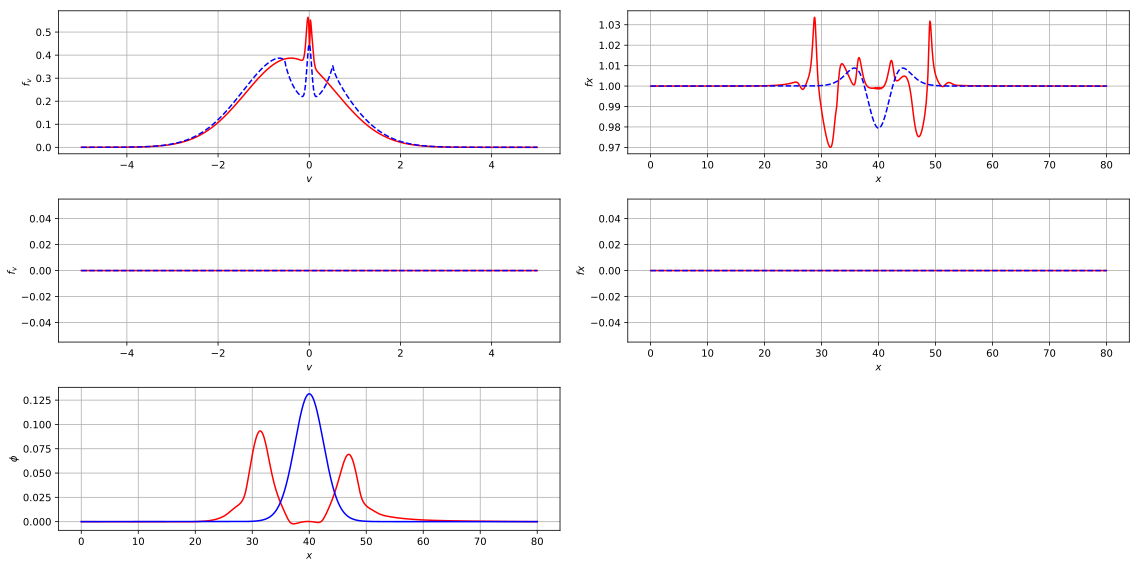

In [124]:
fig = plt.figure(figsize=(16, 8))
xzero = int(nx/2)

ax1 = plt.subplot(321)
ax1.plot(v, fe[test_frame][xzero,:], color='red')
ax1.plot(v, fe[0][xzero,:],'--', color='blue')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_{v}$')
# ax1.set_yscale('log')
ax1.grid()

ax2 = plt.subplot(322)
ax2.plot(x, fex, color='red')
ax2.plot(x, fex0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$fx$')
ax2.grid()

ax3 = plt.subplot(323)
ax3.plot(v, fi[test_frame][xzero,:], color='red')
ax3.plot(v, fi[0][xzero,:],'--', color='blue')
# ax1.plot(v, fi[data_num-1][xzero,:],'--', color='blue')
ax3.set_xlabel(r'$v$')
ax3.set_ylabel(r'$f_{v}$')
# ax1.set_yscale('log')
ax3.grid()

ax4 = plt.subplot(324)
ax4.plot(x, fix, color='red')
ax4.plot(x, fix0,'--', color='blue')
ax4.set_xlabel(r'$v$')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$fx$')
ax4.grid()

ax5 = plt.subplot(325)
ax5.plot(x, phi[test_frame], color='red')
ax5.plot(x, phi[0],'-', color='blue')
# ax5.plot(x, phi_sc,'--', color='black')
ax5.set_xlabel(r'$x$')
ax5.set_ylabel(r'$\phi$')
ax5.grid()

plt.tight_layout()
plt.show()

In [125]:
Ze = fe[test_frame]
Ze[np.where(Ze<=0)]=0
Zi = fi[test_frame]
Zi[np.where(Zi<=0)]=0
lve_idx = np.linspace(-2,0,num=30)
lve = 10**lve_idx
lvi_idx = np.linspace(-40,1,num=20)
lvi = 10**lvi_idx
vle = 1.5
vli = 1.5

fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot(221)
ax1cm = ax1.contourf(X, V, fe[0], levels=lve,norm=colors.LogNorm(vmin=lve.min(),vmax=lve.max()),cmap=cm.plasma)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$v$')
# ax1.set_xlim(40,60)
ax1.set_ylim(-vle,vle)
ax1.set_title(r'$t=0$')

ax2 = plt.subplot(222)
ax2cm = ax2.contourf(X, V, Ze, levels=lve,norm=colors.LogNorm(vmin=lve.min(),vmax=lve.max()),cmap=cm.plasma)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$v$')
ax2.set_ylim(-vle,vle)
# ax2.grid()
ax2.set_title(r'$t=$'+str(test_frame*data_steps*dt))

# ax3 = plt.subplot(223)
# ax3.contourf(X, V, fe[0]-Ze, levels=lve,norm=colors.LogNorm(vmin=lve.min(),vmax=lve.max()),cmap=cm.plasma)
# ax3.set_xlabel(r'$x$')
# ax3.set_ylabel(r'$v$')
# ax3.set_ylim(-vle,vle)

# ax3 = plt.subplot(223)
# ax3.contourf(X, V, fi[0], levels=lvi,norm=colors.LogNorm(vmin=lvi.min(),vmax=lvi.max()),cmap=cm.plasma)
# ax3.set_xlabel(r'$x$')
# ax3.set_ylabel(r'$v$')
# ax3.set_ylim(-vli,vli)

# ax4 = plt.subplot(224)
# ax4.contourf(X, V, Zi, levels=lvi,norm=colors.LogNorm(vmin=lvi.min(),vmax=lvi.max()),cmap=cm.plasma)
# ax4.set_xlabel(r'$x$')
# ax4.set_ylabel(r'$v$')
# ax4.set_ylim(-vli,vli)
plt.show()